In [1]:
import tensorflow as tf
from tensorflow import keras
%matplotlib inline
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from keras.layers import LeakyReLU


Using TensorFlow backend.


In [2]:
import os
import cv2
import numpy as np
from keras import layers
from keras.layers import Input,Add,Dense,Activation,ZeroPadding2D,BatchNormalization,Flatten,Conv2D,AveragePooling2D,MaxPooling2D
from keras.models import Model,load_model
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import tensorflow as tf
from tensorflow.keras import backend as k

In [3]:
class MyCustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('acc') >= 0.96):   
            print("Reached 95% accuracy so cancelling training!")
            self.model.stop_training = True

In [12]:
EPOCHS = 50
INIT_LR = 3e-3
BS =15
default_image_size = tuple((150, 150))
image_size = 0
width=150
height=150
depth=3
train_dir=r"D:\DP\bloodcell\images\TRAIN"
#valid_dir=r"C:\Users\Glau\Desktop\DP\Pediastrum_cnn\Test"
train_folder=listdir(train_dir)
#valid_folder=listdir(valid_dir)

In [5]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [6]:
callbacks = MyCustomCallback()

In [8]:
train_image_list, train_image_label= [], []
for disease_folder in train_folder:
    print(f"processing {disease_folder} ...")
    disease_img_folder= listdir(f"{train_dir}/{disease_folder}")
    #print(disease_img_folder)
    for disease_img in disease_img_folder:
    #for disease_img in disease_img_folder[: : 2]:    
        image_directory = f"{train_dir}/{disease_folder}/{disease_img}"
        if image_directory.endswith(".jpeg") == True or image_directory.endswith(".TIFF") == True or  image_directory.endswith(".png") == True:
            train_image_list.append(convert_image_to_array(image_directory))
            train_image_label.append(disease_folder)
print("[INFO] Image loading completed")

processing EOSINOPHIL ...
processing LYMPHOCYTE ...
processing MONOCYTE ...
processing NEUTROPHIL ...
[INFO] Image loading completed


In [13]:
print(len(train_image_label))

12436


In [14]:
label_binarizer = LabelBinarizer()
bin_train_image_labels = label_binarizer.fit_transform(train_image_label)
#bin_valid_image_labels = label_binarizer.fit_transform(valid_image_label)
pickle.dump(label_binarizer,open('Label_Instance_cancer_cell_Res_new2.pk', 'wb'))
n_classes = len(label_binarizer.classes_)

In [15]:
print(len(bin_train_image_labels))

12436


In [16]:
print(len(bin_train_image_labels))

12436


In [17]:
np_train_image_list = np.array(train_image_list, dtype=np.float32) / 255.0

In [18]:
print(len(np_train_image_list))

12436


In [36]:
def identity_block(X,f,filters,stage,block):
    #defining name basis
    conv_name_base='res'+str(stage)+block+'_branch'
    bn_name_base='bn'+str(stage)+block+'_branch'
    #Retrieve filters
    F1,F2,F3=filters
    #save the input value. we will need this later to add back to main path
    X_shortcut=X
    #First component of main path
    X=Conv2D(filters=F1,kernel_size=(1,1),strides=(1,1),padding='valid',name=conv_name_base+'2a',kernel_initializer=glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3,name=bn_name_base+'2a')(X)
    X=Activation('relu')(X)
    
    #second component of main path
    X=Conv2D(filters=F2,kernel_size=(f,f),strides=(1,1),padding='same',name=conv_name_base+'2b',kernel_initializer=glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3,name=bn_name_base+'2b')(X)
    X=Activation('relu')(X)
    #third component of main path
    X=Conv2D(filters=F3,kernel_size=(1,1),strides=(1,1),padding='valid',name=conv_name_base+'2c',kernel_initializer=glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3,name=bn_name_base+'2c')(X)
    
    # Final step : Add shortcut value to main path and pass it through RELU activation
    X=Add()([X,X_shortcut])
    X=Activation('relu')(X)
    return X
    

In [37]:
from tensorflow.python.framework import ops
ops.reset_default_graph()
#tf.reset_default_graph()
with tf.compat.v1.Session() as test:
    A_prev=tf.compat.v1.placeholder("float",[3,4,4,6])
    X=np.random.randn(3,4,4,6)
    A=identity_block(A_prev,f=2,filters=[2,4,6],stage=1,block='a')
    test.run(tf.compat.v1.global_variables_initializer())
    out=test.run([A],feed_dict={A_prev:X,k.learning_phase():0})
    print("out= ",out[0][1][1][0])

out=  [0.         0.         1.0987326  0.         0.9822005  0.36759973]


In [38]:
def convolutional_block(X,f,filters,stage,block,s=2):
    #defining name basis
    conv_name_base='res'+str(stage)+block+'_branch'
    bn_name_base='bn'+str(stage)+block+'_branch'
    #Retrieve filters
    F1,F2,F3=filters
    #save the input value. we will need this later to add back to main path
    X_shortcut=X
    #First component of main path
    X=Conv2D(filters=F1,kernel_size= (1,1), strides=(s,s),name=conv_name_base +'2a',kernel_initializer=glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3,name=bn_name_base+'2a')(X)
    X=Activation('relu')(X)
    
    #second component of main path
    X=Conv2D(filters=F2,kernel_size=(f,f),strides=(1,1),padding='same',name=conv_name_base +'2b',kernel_initializer=glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3,name=bn_name_base+'2b')(X)
    X=Activation('relu')(X)
    #third component of main path
    X=Conv2D(filters=F3,kernel_size=(1,1),strides=(1,1),padding='valid',name=conv_name_base+'2c',kernel_initializer=glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3,name=bn_name_base+'2c')(X)
    
    #Shortcut path
    X_shortcut=Conv2D(F3,kernel_size=(1,1),strides=(1,1),name=conv_name_base+'1',kernel_initializer=glorot_uniform(seed=0))(X)
    X_shortcut=BatchNormalization(axis=3,name=bn_name_base+'1')(X_shortcut)
    # Final step : Add shortcut value to main path and pass it through RELU activation
    X=Add()([X,X_shortcut])
    X=Activation('relu')(X)
    return X

In [39]:
from tensorflow.python.framework import ops
ops.reset_default_graph()
#tf.reset_default_graph()
with tf.compat.v1.Session() as test:
    A_prev=tf.compat.v1.placeholder("float",[3,4,4,6])
    X=np.random.randn(3,4,4,6)
    A=convolutional_block(A_prev,f=2,filters=[2,4,6],stage=1,block='a')
    test.run(tf.compat.v1.global_variables_initializer())
    out=test.run([A],feed_dict={A_prev:X,k.learning_phase():0})
    print("out= ",out[0][1][1][0])

out=  [0.7675995 1.6447864 1.8606353 0.9949514 1.3454818 1.3538616]


In [40]:
def ResNet50(input_shape=(width,height,depth),classes=4):
    #Define the input as a tensor with shape input_shape
    X_input=Input(input_shape)
    #Zeror_padding
    X=ZeroPadding2D((3,3))(X_input)
    #stage 1
    X=Conv2D(32,(3,3),strides=(2,2),name='conv1',kernel_initializer=glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3,name='bn_conv1')(X)
    X=Activation('relu')(X)
    X=MaxPooling2D((3,3),strides=(2,2))(X)
    #stage 2
    X=convolutional_block(X,f=3,filters=[32,32,64],stage=2,block='a',s=1)
    X=identity_block(X,3,[32,32,64],stage=2,block='b')
    X=identity_block(X,3,[32,32,64],stage=2,block='c')
    #stage 3
    X=convolutional_block(X,f=3,filters=[64,64,128],stage=3,block='a',s=2)
    X=identity_block(X,3,[64,64,128],stage=3,block='b')
    X=identity_block(X,3,[64,64,128],stage=3,block='c')
    X=identity_block(X,3,[64,64,128],stage=3,block='d')
    
    #stage 4
    X=convolutional_block(X,f=3,filters=[128,128,512],stage=4,block='a',s=2)
    X=identity_block(X,3,[128,128,512],stage=4,block='b')
    X=identity_block(X,3,[128,128,512],stage=4,block='c')
    X=identity_block(X,3,[128,128,512],stage=4,block='d')
    X=identity_block(X,3,[128,128,512],stage=4,block='e')
    X=identity_block(X,3,[128,128,512],stage=4,block='f')
    
    #stage 5
    X=convolutional_block(X,f=3,filters=[512,512,2048],stage=5,block='a',s=2)
    X=identity_block(X,3,[512,512,2048],stage=5,block='b')
    X=identity_block(X,3,[512,512,2048],stage=5,block='c')
    
    #AVGpool
    X=AveragePooling2D((2,2),name='avg_pool')(X)
    
    #outer Layer
    X=Flatten()(X)
    X=Dense(classes,activation='softmax',name='fc'+str(classes),kernel_initializer=glorot_uniform(seed=0))(X)
    
    #create model
    model=Model(inputs=X_input,outputs=X,name='ReSNet50')
    return model

In [41]:
ROWS=150
COLS=150
CHANNEL=3
CLASSES=4

In [42]:
model=ResNet50(input_shape=(ROWS,COLS,CHANNEL),classes=CLASSES)

In [43]:
print(model.summary())

Model: "ReSNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 156, 156, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 77, 77, 32)   896         zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 77, 77, 32)   128         conv1[0][0]                      
___________________________________________________________________________________________

In [44]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

In [45]:
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

print("[INFO] training network...")

[INFO] training network...


In [46]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,classification_report 
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import cohen_kappa_score 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Normalizer

In [ ]:
conf_matrix_list_of_arrays = []
#loss_per_fold = []
seed = 13   # for reproducibility you can change it. 
np.random.seed(seed)
kfold = KFold(5, True, seed)
for train_idx, val_idx in kfold.split(np_train_image_list, y=bin_train_image_labels):
    #print('train: %s, val: %s' % (train_idx, val_idx))
    x_train, x_val = np_train_image_list[train_idx], np_train_image_list[val_idx]
    y_train, y_val = bin_train_image_labels[train_idx], bin_train_image_labels[val_idx]
    history=model.fit(x_train, y_train,
                  validation_data=(x_val, y_val),
                  batch_size=BS,
                  epochs=EPOCHS, verbose=1        
                  )
    ycalculated = model.predict(x_val)
    yhat_classes =np.argmax(ycalculated,axis=1)
    rounded_labels=np.argmax(y_val,axis=1)                           
    conf_matrix = confusion_matrix(rounded_labels,yhat_classes)
    conf_matrix_list_of_arrays .append(conf_matrix)

Train on 9948 samples, validate on 2488 samples
Epoch 1/50
9948/9948 [==============================] - 90s 9ms/step - loss: 1.3489 - accuracy: 0.4700 - val_loss: 1.2262 - val_accuracy: 0.5350
Epoch 2/50
9948/9948 [==============================] - 74s 7ms/step - loss: 0.6533 - accuracy: 0.7315 - val_loss: 0.9510 - val_accuracy: 0.7018
Epoch 3/50
9948/9948 [==============================] - 74s 7ms/step - loss: 0.4942 - accuracy: 0.8020 - val_loss: 5.6519 - val_accuracy: 0.3328
Epoch 4/50
9948/9948 [==============================] - 74s 7ms/step - loss: 0.3737 - accuracy: 0.8557 - val_loss: 3.1514 - val_accuracy: 0.4051
Epoch 5/50
9948/9948 [==============================] - 75s 8ms/step - loss: 0.2772 - accuracy: 0.8888 - val_loss: 3.3546 - val_accuracy: 0.5125
Epoch 6/50
9948/9948 [==============================] - 76s 8ms/step - loss: 0.2629 - accuracy: 0.8999 - val_loss: 0.7773 - val_accuracy: 0.6897
Epoch 7/50
9948/9948 [==============================] - 75s 8ms/step - loss: 0.260

In [ ]:
for i in range(0,5):
    print(conf_matrix_list_of_arrays[i])
#print(cm)

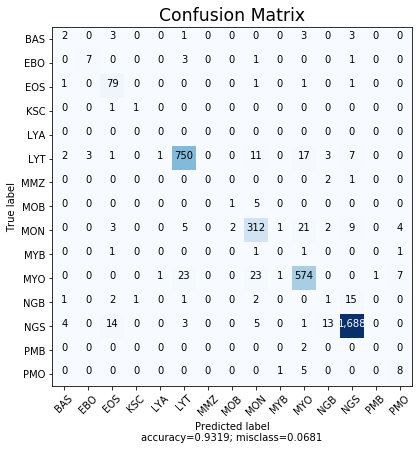

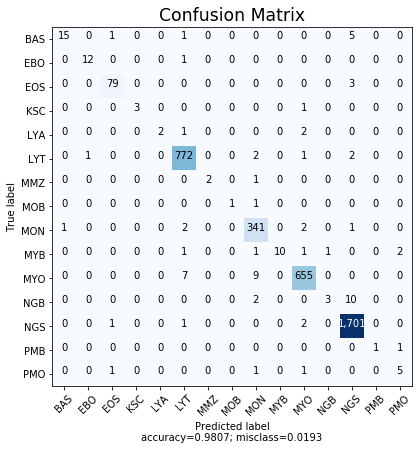

IndexError: list index out of range

In [28]:
import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 'xx-large')

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
for i in range(0,3):
    plot_confusion_matrix(conf_matrix_list_of_arrays[i], 
                      normalize = False,
                      target_names = ['BAS', 'EBO', 'EOS','KSC','LYA','LYT','MMZ','MOB','MON','MYB','MYO','NGB','NGS','PMB','PMO'],
                      title  = "Confusion Matrix")

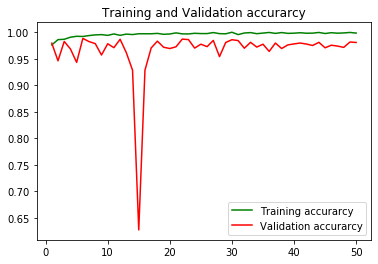

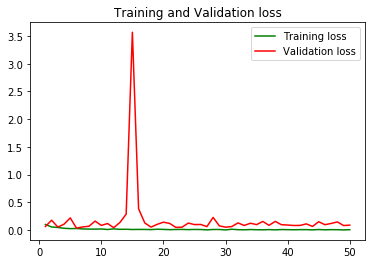

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'g', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [30]:
from sklearn.metrics import accuracy_score,classification_report 
target_names = ['BAS', 'EBO', 'EOS','KSC','LYA','LYT','MMZ','MOB','MON','MYB','MYO','NGB','NGS','PMB','PMO']
print(classification_report(rounded_labels, yhat_classes, target_names=target_names))

              precision    recall  f1-score   support

         BAS       0.94      0.68      0.79        22
         EBO       0.92      0.92      0.92        13
         EOS       0.96      0.96      0.96        82
         KSC       1.00      0.75      0.86         4
         LYA       1.00      0.40      0.57         5
         LYT       0.98      0.99      0.99       778
         MMZ       1.00      0.67      0.80         3
         MOB       1.00      0.50      0.67         2
         MON       0.95      0.98      0.97       347
         MYB       1.00      0.62      0.77        16
         MYO       0.98      0.98      0.98       671
         NGB       0.75      0.20      0.32        15
         NGS       0.99      1.00      0.99      1705
         PMB       1.00      0.50      0.67         2
         PMO       0.62      0.62      0.62         8

    accuracy                           0.98      3673
   macro avg       0.94      0.72      0.79      3673
weighted avg       0.98   

In [31]:
class_to_label_map={ 0 : 'BAS', 1 :'EBO', 2:'EOS',3:'KSC',4:'LYA',5:'LYT',6:'MMZ',7:'MOB',8:'MON',9:'MYB',10:'MYO',11:'NGB',12:'NGS',13:'PMB',14:'PMO'}

C:\Users\Glau\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


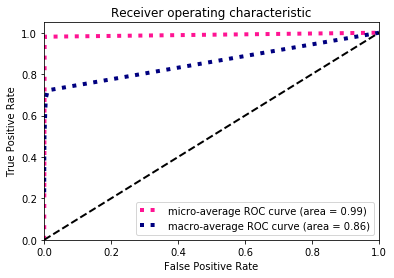

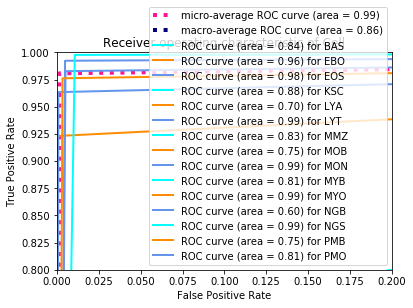

In [32]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

n_classes =15

from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2
lb = LabelBinarizer()
lb.fit(rounded_labels)
y_test= lb.transform(rounded_labels)
snn_pred = lb.transform(yhat_classes)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], snn_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), snn_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes-97), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(15), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], class_to_label_map[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw,color='white')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of Cell')
plt.legend(loc="lower right")
plt.show()


In [68]:
model.save("model_cancer_ResNet_new.h5")

C:\Users\Glau\.conda\envs\tensorflow\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '
